In [2]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [1]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn

In [67]:
file_path = '../Datasets/updataset_clean.xlsx'
df_original = pd.read_excel(file_path)
df_original.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,0.460416,0.460844,0.707107,0.843281,0.378529,0.659899,0.434507,0.384064,0.434493,...,0,0.0,0.0,0.0,0,0,0,0.0,0,0.0
1,1,0.526279,0.526685,0.278318,0.691493,0.713980,0.805620,0.581212,0.520988,0.581175,...,0,0.0,0.0,0.0,0,0,0,0.0,0,0.0
2,1,0.076583,0.076808,0.882232,0.956513,0.417235,0.655363,0.499738,0.454191,0.498176,...,0,0.0,0.0,0.0,0,0,0,0.0,0,0.0
3,1,0.370459,0.370898,0.468582,0.739533,0.619348,0.779343,0.508303,0.447901,0.508281,...,0,0.0,0.0,0.0,0,0,0,0.0,0,0.0
4,1,0.100530,0.100797,0.715222,0.847785,0.480844,0.000000,0.474608,0.420754,0.474570,...,0,0.0,0.0,0.0,0,0,0,0.0,0,0.0


In [68]:
file_path = '../Features/rabbit_corrvar.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,AvgIpc,...,fr_ketone_Topliss,fr_methoxy,fr_nitro,fr_nitro_arom_nonortho,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_unbrch_alkane,fr_urea
0,1,0.380977,0.301948,0.403803,0.385193,0.187251,0.199575,0.550820,0.588235,0.452681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277350,0.0
1,1,0.443959,0.118847,0.725612,0.470253,0.326442,0.202175,0.550534,0.560784,0.542612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1,0.049599,0.376730,0.440935,0.382546,0.249141,0.032276,0.304644,0.633987,0.404010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160128,0.0
3,1,0.297132,0.200094,0.634828,0.454915,0.257268,0.120148,0.629576,0.650624,0.467685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1,0.067411,0.305414,0.501957,0.647698,0.225299,0.075490,0.315990,0.835294,0.471625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [69]:
df = df_original[list(df.columns)]

In [70]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [71]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 353 samples
Test set: 89 samples


In [72]:
xgb_model = joblib.load("xgb_model.pkl")
rf_model = joblib.load("rf_model.pkl")
dt_model = joblib.load("dt_model.pkl")
knn_model = joblib.load("knn_model.pkl")
svm_model = joblib.load("svm_model.pkl")


In [75]:
import pandas as pd

# Get base model predictions (stacking inputs)
stacking_inputs = np.column_stack([
    rf_model.predict(X_test),
    svm_model.predict(X_test),
])

# Fit a simple Logistic Regression model for interpretability
meta_model = LogisticRegression()
meta_model.fit(stacking_inputs, y_test)

# Check coefficients to see which models contribute most
coefs = pd.DataFrame(meta_model.coef_, columns=[ "rf", "svm"])
print(coefs)


         rf       svm
0  0.596075  0.766302


In [76]:
stacking_inputs = np.column_stack([
    rf_model.predict(X_test),
    svm_model.predict(X_test),
])

meta_model.fit(stacking_inputs, y_test)
meta_preds = meta_model.predict(stacking_inputs)
test_accuracy = accuracy_score(y_test, meta_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Perform k-fold cross-validation
cv_scores = cross_val_score(meta_model, stacking_inputs, y_test, cv=5, scoring='accuracy')

# Print mean and standard deviation of cross-validation scores
print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f}")
print(f"Cross-validation standard deviation: {cv_scores.std():.4f}")

Test Accuracy: 0.5730
Cross-validation mean accuracy: 0.5719
Cross-validation standard deviation: 0.0959


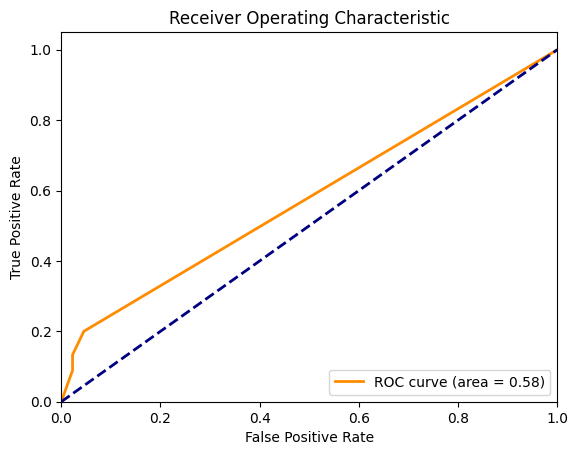

In [77]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities for the positive class (1) from the meta_model
# For logistic regression, we use predict_proba to get probabilities
meta_model_prob = meta_model.predict_proba(stacking_inputs)[:, 1]  # Probabilities for class 1

# Compute ROC curve and ROC AUC for the meta-model
fpr, tpr, thresholds = roc_curve(y_test, meta_model_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [149]:
from sklearn.ensemble import VotingClassifier
voting_hard = VotingClassifier(
    estimators=[
        ('rf', rf_model), 
        ('dt', dt_model), 
        ('knn', knn_model), 
        ('svm', svm_model)
    ],
    voting='hard'  # Majority voting
)
voting_hard.fit(X_train, y_train)
y_pred_hard = voting_hard.predict(X_test)
acc_hard = accuracy_score(y_test, y_pred_hard)
print(acc_hard)

0.8426966292134831


In [ ]:
y_probs = voting_hard.predict_proba(X_test)[:, 1]  # Get probability of the positive class
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Voting Classifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Voting Classifier')
plt.legend(loc='lower right')
plt.show()